# 获取宏观数据

本讲以 `pandas_datareader` 为例，介绍如何获取宏观数据。

FRED 是美国联邦储备银行提供的宏观经济数据，包含了大量的经济指标。
FRED 提供了一个 API 接口，可以通过 `pandas_datareader` 来获取数据。

本文写作过程中借助了 AI，包括 ChatGPT ([提示词](https://chatgpt.com/share/6818e458-538c-8005-9af1-1a8c31ee50f1)) 和 Github Coplilot。

## 下载美国失业率数据

> Source: U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis; <https://fred.stlouisfed.org/series/UNRATE>, May 5, 2025. 

In [ ]:
# 基本设定

import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import datetime

import warnings
warnings.filterwarnings("ignore")  # 屏蔽警告信息

# 设置起止日期 (后续其他宏观变量也采用这个设置)
start_date = datetime.datetime(1960, 1, 1)
end_date = datetime.datetime.today()
start_year = start_date.year

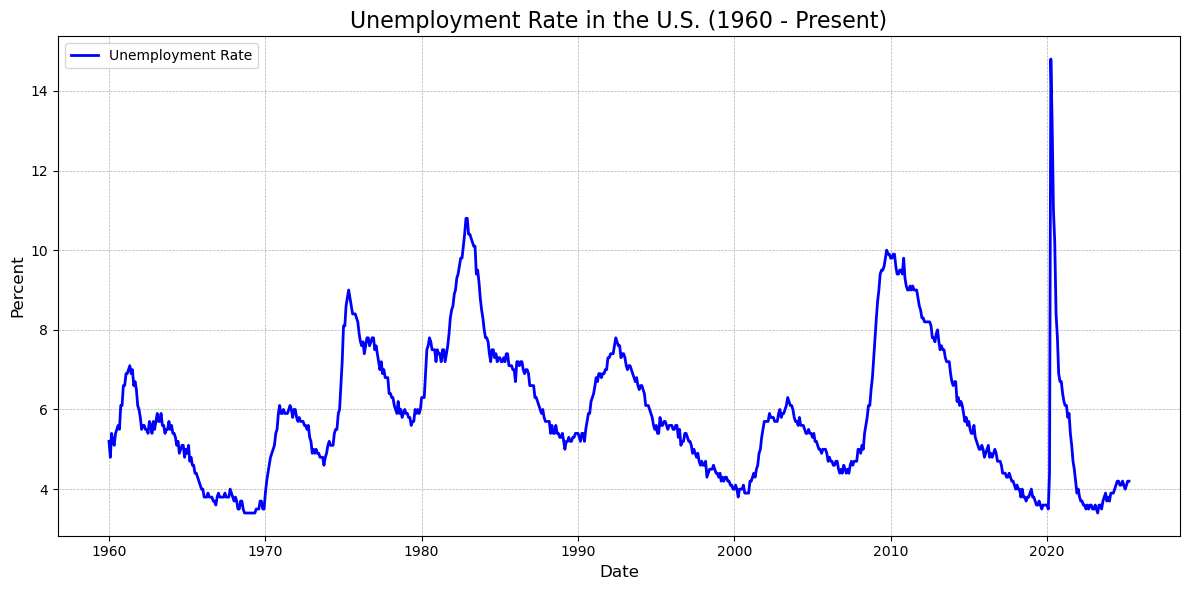

In [15]:
# 失业率

# 从 FRED 获取“Unemployment Rate”数据（代码为 UNRATE）
df_unemp = DataReader("UNRATE", "fred", start_date, end_date)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_unemp.index, df_unemp["UNRATE"], 
         color='blue', linewidth=2, label='Unemployment Rate')

# 图形美化
plt.title(f"Unemployment Rate in the U.S. ({start_year} - Present)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percent", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# 显示图形
plt.show()


## 美国失业率的时序特征

上图展示了自 1960 年以来美国的月度失业率变化趋势。总体来看，美国失业率呈现出显著的**周期性波动**，其高峰通常与经济衰退期相吻合，低谷则出现在经济扩张阶段。

- **周期波动明显**：失业率大致每 8-10 年出现一次较大波动，与美国历次经济衰退（如 1974、1982、1991、2008 和 2020 年）高度对应。
- **历史极值**：2020 年新冠疫情爆发初期，失业率迅速飙升至超过 14%，为图中最高点，反映出突发公共卫生事件对劳动市场的巨大冲击。
- **长期下行趋势**：尽管存在周期性波动，但在部分阶段（如 1982-2000 年间、2010-2019 年间）可观察到失业率逐步下降的趋势，显示出结构性改善可能性。

### 问题：如何分析失业率的时序特征？

从图中失业率的走势出发，我们可以从以下几个角度提出计量建模中需要关注的核心问题：

* **平稳性与周期性：**
  失业率呈现一定的均值回复特征 (在上图中，均值约为 6Z%)，但是否真正平稳？如何通过单位根检验（如 ADF 检验）判断？如果该序列非平稳，我们是否应进行差分处理以便后续建模？

* **结构性突变：**
  例如 2020 年的断崖式上升显然并非常态波动，这提示我们应考虑模型中可能存在的**结构突变（structural break）**。在传统 ARIMA 模型之外，我们可能需要引入 regime-switching 或 dummy 变量来捕捉这类异质性。

* **滞后依赖结构：**
  当前失业率是否受到过去若干期值的影响？其滞后项在建模中如何体现？这正是 AR(p) 或 ARMA(p, q) 模型关注的核心。

* **长期关系与协整：**
  若将失业率与其他宏观变量（如通货膨胀率、GDP 增长率）联合考虑，它们之间是否存在协整关系？若存在，应如何建立误差修正模型（ECM）？

* **波动性建模：**
  某些阶段的波动显著大于其他时期，例如 1970s 或 2008 危机期间。如何刻画这种**条件异方差**特征？这将引出 ARCH/GARCH 及其扩展模型的讨论。


In [47]:
# 失业率的基本统计特征
umemp = df_unemp["UNRATE"]
print("失业率的基本统计特征：")
print(umemp.describe().round(2))

失业率的基本统计特征：
count    784.00
mean       5.88
std        1.70
min        3.40
25%        4.60
50%        5.60
75%        7.00
max       14.80
Name: UNRATE, dtype: float64


In [ ]:
# 分时段统计 (表格版)
periods = {
    "1960-1980年": ("1960-01-01", "1980-12-31"),
    "1980-2000年": ("1980-01-01", "2000-12-31"),
    "2000-2010年": ("2000-01-01", "2010-12-31"),
    "2010-2020年": ("2010-01-01", "2020-12-31"),
    "2020-2025年": ("2020-01-01", "2025-12-31"),
}

# 创建一个列表来存储结果
stats_list = []

for period, (start, end) in periods.items():
    stats = umemp[start:end].agg(['mean', 'std', 'min', 'max']).round(2)
    stats_list.append({
        "Period": period,
        "Mean": stats["mean"],
         "Std": stats["std"],
         "Min": stats["min"],
         "Max": stats["max"]
    })

# 将结果转换为 DataFrame
stats_table = pd.DataFrame(stats_list)

# 显示结果表格
print(stats_table)

       Period  Mean   Std  Min   Max
0  1960-1980年  5.58  1.35  3.4   9.0
1  1980-2000年  6.40  1.55  3.8  10.8
2  2000-2010年  5.91  1.81  3.8  10.0
3  2010-2020年  6.39  2.29  3.5  14.8
4  2020-2025年  4.90  2.28  3.4  14.8


## 10 年移动平均

我们可以使用 `rolling` 函数来计算 10 年移动平均，以便从更长时间尺度上观察失业率的变化趋势。


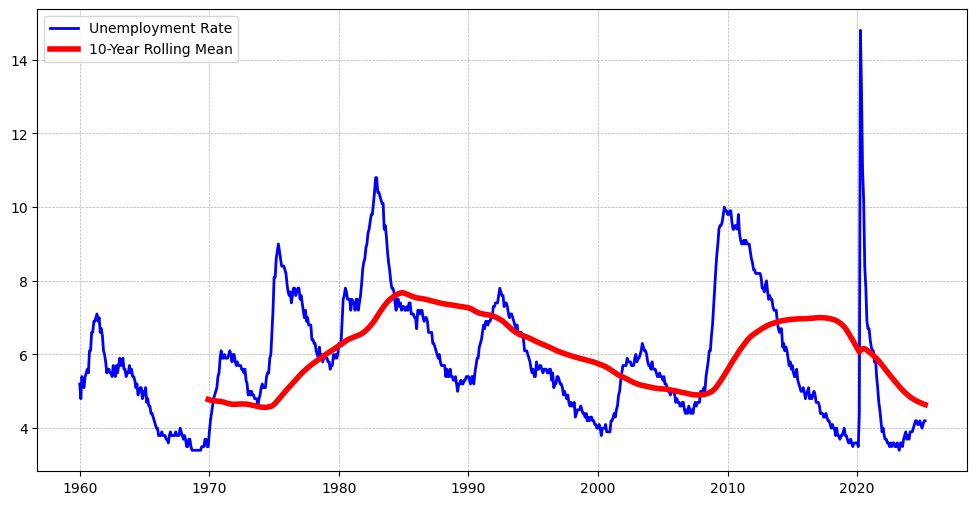

In [54]:
# 10 年和 5 年滚动平均
rolling_mean_umemp_10yr = umemp.rolling(window=120).mean()  # 120 个月 = 10 年

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_unemp.index, umemp, 
         color='blue', linewidth=2, label='Unemployment Rate')
plt.plot(df_unemp.index, rolling_mean_umemp_10yr, 
         color='red', linewidth=4, label='10-Year Rolling Mean')
plt.legend() # 添加图例
plt.grid(True, linestyle='--', linewidth=0.5) # 添加网格线

### $AR(p)$ 模型

在时间序列分析中，$AR(p)$ 模型是最基本的模型之一。它假设当前值与过去 $p$ 个时刻的值存在线性关系。一般形式为：

$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_p X_{t-p} + \epsilon_t \tag{1}
$$

其中，$\phi_1, \phi_2, ..., \phi_p$ 是模型参数，$\epsilon_t$ 是白噪声项。

#### $AR(1)$ 模型
当 $p=1$ 时，$AR(1)$ 模型为：

$$
X_t = \phi_1 X_{t-1} + \epsilon_t \tag{2}
$$

虽然看起来很简单，但 $AR(1)$ 模型在时间序列分析中非常重要，因为它可以捕捉到数据的自相关性。从模型设定形式上来看，它具有递推的特征，当前值仅与前一个值相关。

具体而言，(2) 式在 $t-1$ 时刻可以表示为：

$$
X_{t-1} = \phi_1 X_{t-2} + \epsilon_{t-1} \tag{3}
$$

将 (3) 式代入 (2) 式中，我们可以得到：

$$
X_t = \phi_1 (\phi_1 X_{t-2} + \epsilon_{t-1}) + \epsilon_t = \phi_1^2 X_{t-2} + \phi_1 \epsilon_{t-1} + \epsilon_t \tag{4}
$$

将 (4) 式继续递推下去，我们可以得到：

$$
X_t = \phi_1^t X_0 + \sum_{i=0}^{t-1} \phi_1^i \epsilon_{t-i} \tag{5}
$$

(5) 式表明，$X_t$ 由初始值 $X_0$ 和过去的随机扰动项 $\epsilon_{t-i}$ 线性组合而成。


举个例子：若 $X_0$ 表示某人 20 岁时的体重，取 $t = 10$，则 $X_{10}$ 表示该人 30 岁时的体重。假设 $X_0 = 60 kg$，$\phi_1 = 0.9$，则 (5) 式的含义是：

- 该人 30 岁时的体重 $X_{10}$，由其 20 岁时的体重 $X_0$ 与过去 10 年中的随机扰动项 $\varepsilon_{t-i}$（如饮食习惯、运动频率、作息变化、疾病史等）线性加权而成。
- 由于 $\phi_1 = 0.9$，而 $\phi_1^{10} = 0.9^{10} \approx 0.35$，说明 20 岁时的初始体重对 30 岁时体重的影响仍然存在，但已显著减弱。体重的变化更多地取决于过去 10 年逐年积累的生活方式等随机因素。
- 模型还体现出“记忆衰减”效应：越接近当前年份的扰动项，其影响越大。例如，$\varepsilon_9$ 的系数为 $\phi_1^1 = 0.9$，$\varepsilon_8$ 的系数为 $\phi_1^2 = 0.81$，$\varepsilon_7$ 的系数为 $\phi_1^3 \approx 0.729$，依此类推，扰动项的影响呈指数递减。

下面，我们来模拟生成几组 $AR(1)$ 过程的数据。

请思考如下几个问题：
- $AR(1)$ 模型能刻画一个人的体重变化吗？
- 不同的 $\phi_1$ 对数据生成有何影响？
- 模拟过程中，假设 $\epsilon_t \sim (0, \sigma^2)$，参数 $\sigma$ 的取值对数据生成有何影响？
- 如何修改这个模型才能更好地刻画一个人的体重变化？

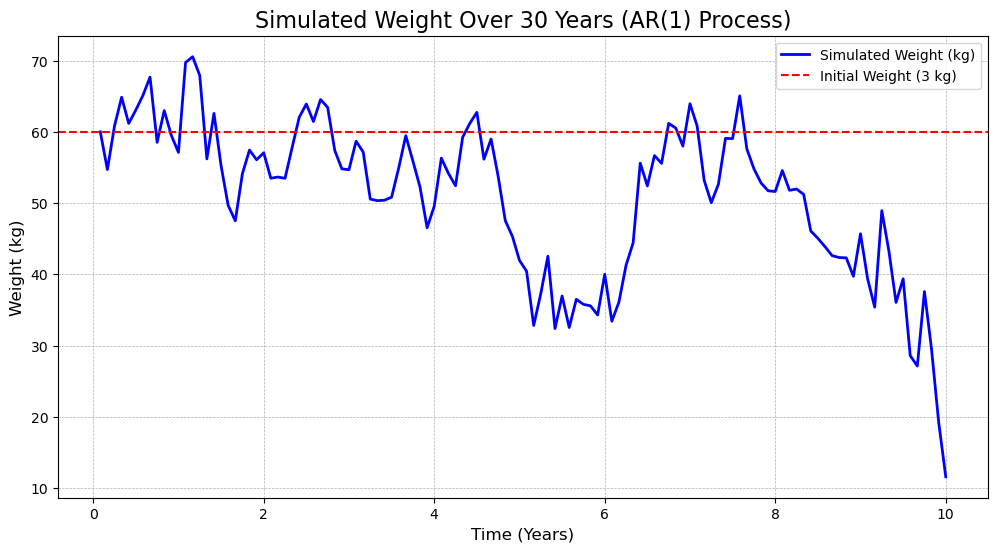

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
phi_1 = 0.99  # AR(1) 系数
sigma = 5  # 随机扰动项的标准差

X_0 = 60      # 初始体重 (kg)
n_years = 10 # 模拟 10 年
n_steps = n_years * 12  # 每年 12 个月

# 随机扰动项 (白噪声)
#np.random.seed(42)  # 固定随机种子以便复现
epsilon = np.random.normal(loc=0, scale=sigma, size=n_steps)

# 模拟 AR(1) 过程
X = np.zeros(n_steps)
X[0] = X_0
for t in range(1, n_steps):
    X[t] = phi_1 * X[t-1] + epsilon[t]

# 绘图
time = np.arange(1, n_steps + 1) / 12  # 时间轴 (以年为单位)
plt.figure(figsize=(12, 6))
plt.plot(time, X, label="Simulated Weight (kg)", color="blue", linewidth=2)
plt.axhline(y=X_0, color="red", linestyle="--", label="Initial Weight (3 kg)")
plt.title("Simulated Weight Over 30 Years (AR(1) Process)", fontsize=16)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Weight (kg)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


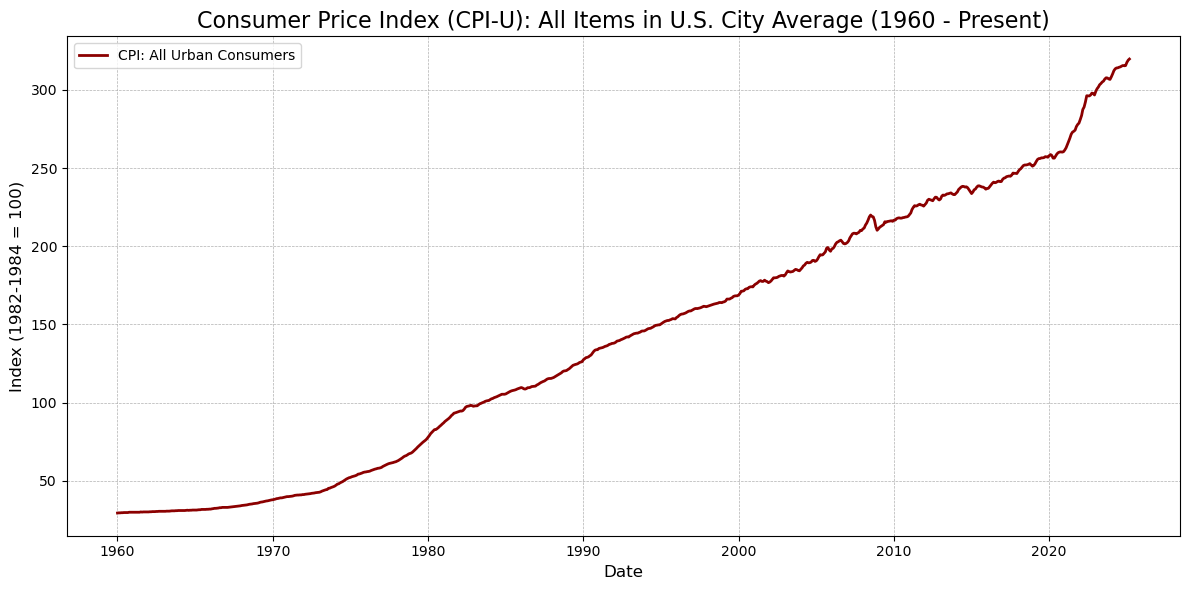

In [16]:
# CPI（消费者物价指数）

# 从 FRED 获取 CPI 数据（代码为 CPIAUCNS）
df_CPI = DataReader("CPIAUCNS", "fred", start_date, end_date)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_CPI.index, df_CPI["CPIAUCNS"], 
         color='darkred', linewidth=2, label='CPI: All Urban Consumers')

# 图形美化
plt.title(f"Consumer Price Index (CPI-U): All Items in U.S. City Average ({start_year} - Present)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Index (1982-1984 = 100)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# 显示图形
plt.show()


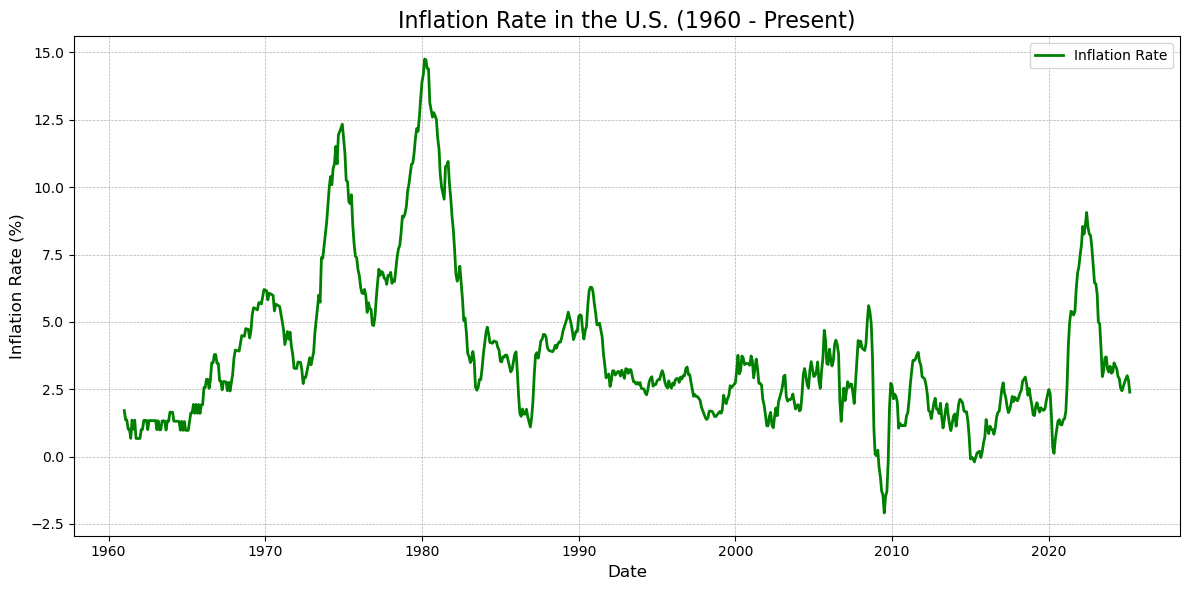

In [17]:
# 基于 CPI 计算通货膨胀率

# 计算通货膨胀率（基于 CPI 的同比变化率）
df_CPI['Inflation Rate'] = df_CPI['CPIAUCNS'].pct_change(periods=12) * 100

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df_CPI.index, df_CPI['Inflation Rate'], 
         color='green', linewidth=2, label='Inflation Rate')

# 图形美化
plt.title(f"Inflation Rate in the U.S. ({start_year} - Present)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inflation Rate (%)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# 显示图形
plt.show()

Text(0.5, -0.05, 'Source: U.S. Bureau of Labor Statistics, FRED (https://fred.stlouisfed.org/)')

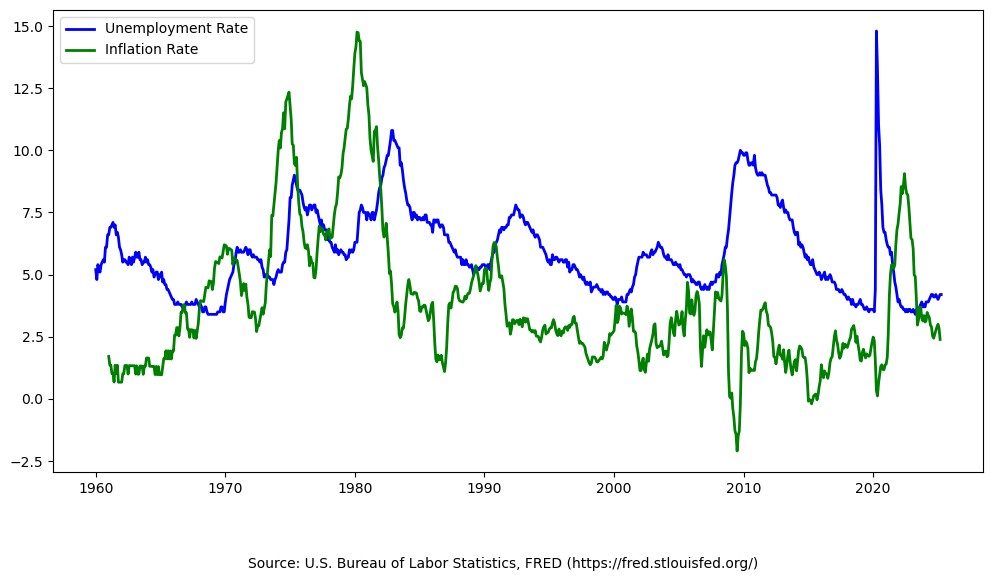

In [41]:
# 绘图：失业率 + 通货膨胀率
plt.figure(figsize=(12, 6))

# 绘制失业率
plt.plot(df_unemp.index, df_unemp["UNRATE"], 
         color='blue', linewidth=2, label='Unemployment Rate')

# 绘制通货膨胀率
plt.plot(df_CPI.index, df_CPI['Inflation Rate'], 
         color='green', linewidth=2, label='Inflation Rate')

# 添加图例
plt.legend(loc='upper left')

# 添加数据来源说明
plt.figtext(0.5, -0.05, "Source: U.S. Bureau of Labor Statistics, FRED (https://fred.stlouisfed.org/)", 
            wrap=True, horizontalalignment='center', fontsize=10)


这幅图展示了 1960 年至今美国 **失业率（Unemployment Rate）** 与 **通胀率（Inflation Rate）** 的时间序列走势。可以从以下几个方面进行解读：

* **趋势与波动性差异**：

  * 失业率（蓝线）表现出相对平稳的周期性波动，具有一定的周期长度；
  * 通胀率（绿线）波动幅度更大，尤其在 1970s 至 1980s 初期，有显著的尖峰。

* **结构性事件的影响**：

  * 1970s：石油危机期间，通胀迅速上升至 13% 以上（即“滞涨”现象），而失业率也居高不下；
  * 2008 金融危机：失业率大幅上升，而通胀保持较低水平；
  * 2020 疫情冲击：失业率暴涨，通胀短暂回落，随后于 2021-2022 再次激增。

* **负相关性阶段**：

  * 在部分阶段（例如 1980s 中后期、1990s、2010s），通胀与失业呈现出某种程度的负相关，符合传统的菲利普斯曲线（Phillips Curve）设定。


## 建模思路

如果我们想建立一个模型来刻画失业率与通胀率之间的关系，有哪些可行的建模思路呢？

In [32]:
# UNRATE 和 Inflation Rate 的关系

## 相关系数
correlation = df_unemp["UNRATE"].corr(df_CPI['Inflation Rate'])
print(f"Correlation between Unemployment Rate and Inflation Rate: {correlation:.2f}")

## OLS 回归分析
import statsmodels.api as sm
# Align the indices of X and Y
X = df_CPI['Inflation Rate'].dropna()   # 自变量
Y = df_unemp["UNRATE"]                  # 因变量
X, Y = X.align(Y, join='inner')         # Align indices
X = sm.add_constant(X)                  # 添加常数项
model = sm.OLS(Y, X).fit()              # OLS 回归
model_summary = model.summary()       # 回归结果
print(model_summary)


Correlation between Unemployment Rate and Inflation Rate: 0.06
                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.016
Date:                Tue, 06 May 2025   Prob (F-statistic):             0.0829
Time:                        00:52:40   Log-Likelihood:                -1505.1
No. Observations:                 771   AIC:                             3014.
Df Residuals:                     769   BIC:                             3024.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [34]:
# ARMA (1,1) 模型：失业率
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

model_unemp = ARIMA(df_unemp['UNRATE'].dropna(), order=(1, 0, 1))
model_unemp_fit = model_unemp.fit()  # Fit the ARIMA model
print(model_unemp_fit.summary())  # Print the model summary

                               SARIMAX Results                                
Dep. Variable:                 UNRATE   No. Observations:                  784
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -446.406
Date:                Tue, 06 May 2025   AIC                            900.812
Time:                        00:54:53   BIC                            919.469
Sample:                    01-01-1960   HQIC                           907.986
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8040      1.075      5.397      0.000       3.696       7.912
ar.L1          0.9640      0.012     82.124      0.000       0.941       0.987
ma.L1          0.0508      0.012      4.417      0.0

In [35]:
# ARMA (1,1) 模型：通胀率

model = ARIMA(df_CPI['Inflation Rate'].dropna(), order=(1, 0, 1))
model_fit = model.fit()     # Fit the ARIMA model
print(model_fit.summary())  # Print the model summary

                               SARIMAX Results                                
Dep. Variable:         Inflation Rate   No. Observations:                  771
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -327.515
Date:                Tue, 06 May 2025   AIC                            663.030
Time:                        00:55:03   BIC                            681.621
Sample:                    01-01-1961   HQIC                           670.185
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5391      1.139      3.108      0.002       1.307       5.771
ar.L1          0.9847      0.005    197.487      0.000       0.975       0.995
ma.L1          0.2964      0.026     11.248      0.0

### 单位根检验

从上面的 $ARMA(1,1)$ 模型的结果来看，$AR(1)$ 系数的估计值为 $0.9847$，接近于 $1$，这表明该序列可能是一个单位根序列。

我们可以使用 `statsmodels` 库中的 `adfuller` 函数来进行单位根检验。

#### ADF 检验
给定一个时间序列 $X_t$，我们可以使用以下的 ADF 检验来检验 $X_t$ 是否是平稳的：
$$
X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_p X_{t-p} + \epsilon_t$$
其中，$\epsilon_t$ 是一个白噪声序列。

ADF 检验的原假设是：$X_t$ 是一个单位根序列，即 $H_0: \phi_1 = 1$。
如果 $H_0$ 被拒绝，则说明 $X_t$ 是平稳的。

ADF 检验包含几种典型的数据生成机制：
- 纯随机游走：$X_t = X_{t-1} + \epsilon_t$，其中 $\epsilon_t$ 是一个白噪声序列。
- 随机游走加趋势：$X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 t + \epsilon_t$，其中 $\epsilon_t$ 是一个白噪声序列，$t$ 是时间趋势项。
- 随机游走加季节性：$X_t = \phi_0 + \phi_1 X_{t-1} + S_t + \epsilon_t$，其中 $\epsilon_t$ 是一个白噪声序列，$S_t$ 是季节性项。
- 随机游走加趋势和季节性：$X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 t + S_t + \epsilon_t$，其中 $\epsilon_t$ 是一个白噪声序列，$t$ 是时间趋势项，$S_t$ 是季节性项。

#### KPSS 检验
KPSS 检验的原假设是：$X_t$ 是平稳的，即 $H_0: \phi_1 < 1$。
如果 $H_0$ 被拒绝，则说明 $X_t$ 是一个单位根序列。

#### PP 检验
PP 检验的原假设是：$X_t$ 是一个单位根序列，即 $H_0: \phi_1 = 1$。
如果 $H_0$ 被拒绝，则说明 $X_t$ 是平稳的。

#### 对比


In [38]:
# 单位根检验
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# ADF 检验
adf_result = adfuller(df_CPI['Inflation Rate'].dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Critical Values: {adf_result[4]}")

# KPSS 检验
kpss_result = kpss(df_CPI['Inflation Rate'].dropna(), regression='c')
print(f"KPSS Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")



ADF Statistic: -3.2255
p-value: 0.0186
Critical Values: {'1%': -3.4390409569041207, '5%': -2.865375732701395, '10%': -2.568812543748081}
KPSS Statistic: 0.8623
p-value: 0.0100


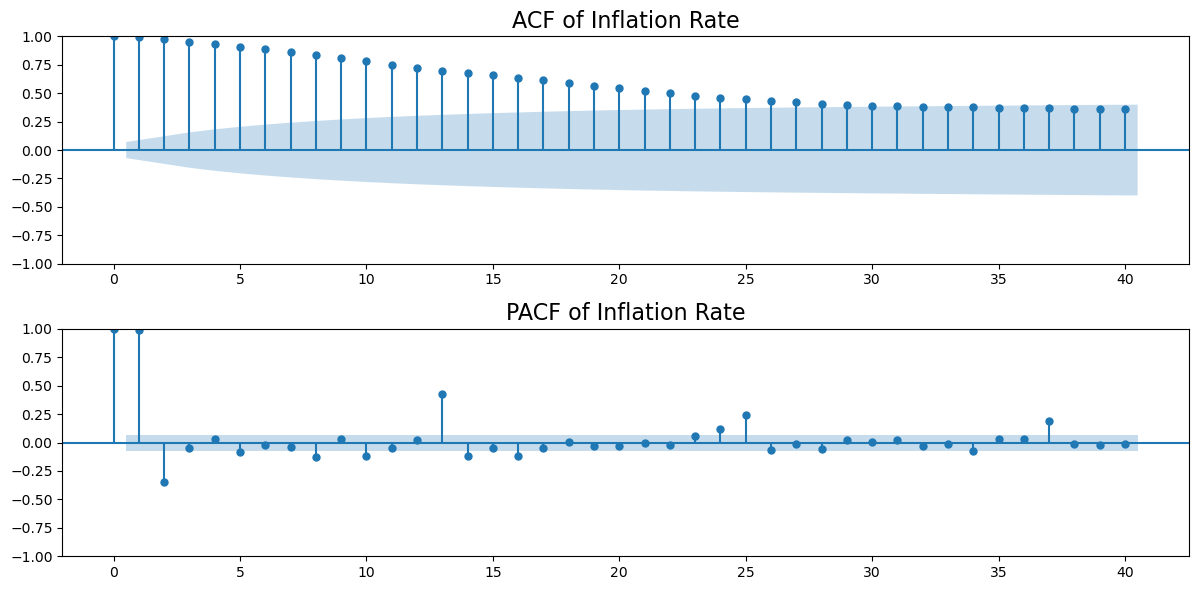

In [ ]:
# 绘制 ACF 和 PACF 图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df_CPI['Inflation Rate'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF of Inflation Rate', fontsize=16)
plt.subplot(2, 1, 2)
plot_pacf(df_CPI['Inflation Rate'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF of Inflation Rate', fontsize=16)
plt.tight_layout()
plt.show()

解读：
上面的图形展示了美国失业率和通货膨胀率的时间序列变化趋势。可以观察到，失业率和通货膨胀率在不同时间段内呈现出一定的波动性。失业率在经济衰退期间通常会显著上升，而通货膨胀率则可能受到多种因素的影响，包括货币政策、供需变化等。通过对比两条曲线，可以进一步分析它们之间的关系，例如是否存在菲利普斯曲线的特征。此外，结合回归分析和相关系数的计算结果，可以定量评估失业率与通货膨胀率之间的相关性。

In [ ]:

## VAR 模型
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts

# 1. 检验平稳性
def test_stationarity(timeseries):
    # 进行ADF检验
    adf_result = adfuller(timeseries)
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    if adf_result[1] <= 0.05:
        print("Reject the null hypothesis: The time series is stationary.")
    else:
        print("Fail to reject the null hypothesis: The time series is non-stationary.")

    # 进行KPSS检验
    kpss_result = kpss(timeseries, regression='c')
    print(f'KPSS Statistic: {kpss_result[0]}')
    print(f'p-value: {kpss_result[1]}')
    if kpss_result[1] <= 0.05:
        print("Reject the null hypothesis: The time series is non-stationary.")
    else:
        print("Fail to reject the null hypothesis: The time series is stationary.")

# 2. 绘制自相关和偏自相关图
def plot_acf_pacf(timeseries):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plot_acf(timeseries, lags=40, ax=ax[0])
    plot_pacf(timeseries, lags=40, ax=ax[1])
    plt.show()

# 3. VAR模型
def fit_var_model(data, maxlags=15):
    model = VAR(data)
    results = model.fit(maxlags=maxlags, ic='aic')
    print(results.summary())
    return results

# 4. Granger因果关系检验
def granger_causality_test(data, max_lag=15):
    test_result = grangercausalitytests(data, max_lag, verbose=True)
    return test_result

# 5. 协整检验
def cointegration_test(data):
    score, p_value, _ = coint(data.iloc[:, 0], data.iloc[:, 1])
    print(f'Cointegration test statistic: {score}')
    print(f'p-value: {p_value}')
    if p_value <= 0.05:
        print("Reject the null hypothesis: The time series are cointegrated.")
    else:
        print("Fail to reject the null hypothesis: The time series are not cointegrated.")

# 6. VAR模型的脉冲响应函数
def impulse_response_function(model, steps=10):
    irf = model.irf(steps)
    irf.plot(orth=False)
    plt.show()

# 7. VAR模型的方差分解
def variance_decomposition(model, steps=10):
    fevd = model.fevd(steps)
    fevd.plot()
    plt.show()

# 8. VAR模型的预测
def forecast_var_model(model, steps=10):
    forecast = model.forecast(model.y, steps=steps)
    forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df_unemp.index[-1] + pd.DateOffset(1), periods=steps, freq='M'), columns=model.names)
    return forecast_df

